In [1]:
import numpy as np
import librosa
from IPython.display import Audio, display
from matplotlib import pyplot as plt
import soundfile as sf
from mystft import stft
import sys
import os

# Add upper directory
current_dir = os.path.dirname(os.path.abspath('vad.ipynb'))
upper_dir = (os.path.join(current_dir, '..'))
sys.path.append(upper_dir)

from utils_global import draw_spec, lpf, audioshow, extract_frames

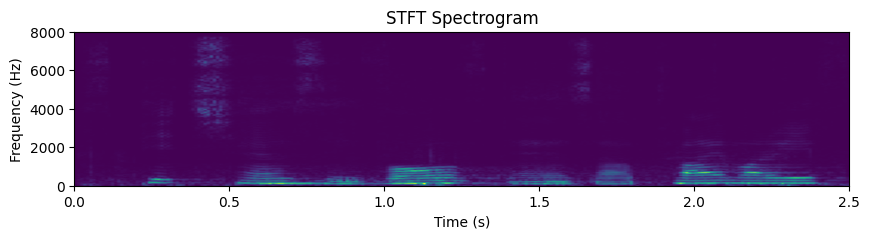

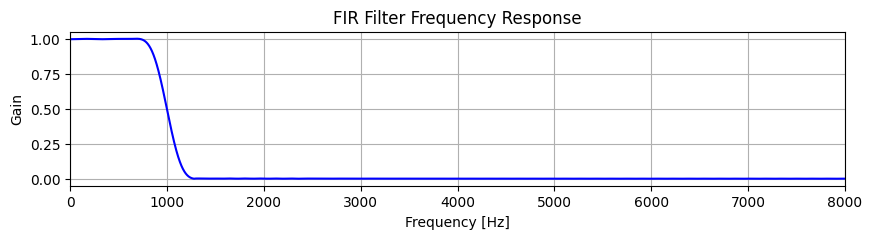

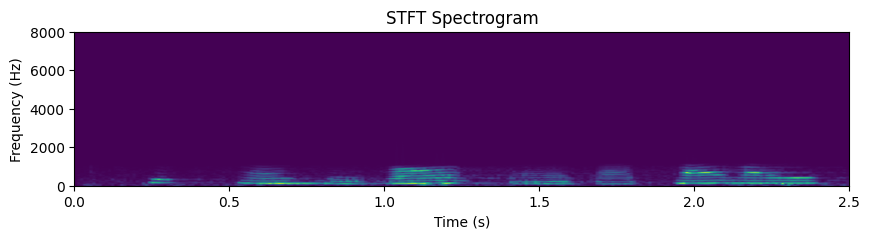

(257, 251)


In [3]:
""" 
Pitch Estimation Module
use AutoCorrelation & AMDF Function

frame len: 20 ms
hop len: 10 ms
"""

## LPF
y, sr = librosa.load("./sample_crop_16kHz.wav", sr=None)
# y, sr = librosa.load("./s5_180_mic1.flac", sr=None)
s = stft(y, win_type='hamming', win_length=320, hop_length=160, n_fft=512, 
         plot=True, use_colorbar=False, figsize=(10,2))
y_lpf = lpf(y, cutoff=1000, plot_resp=True, window='hamming', figsize=(10,2))
s = stft(y_lpf, win_type='hamming', win_length=320, hop_length=160, n_fft=512, 
         plot=True, use_colorbar=False, figsize=(10,2))
print(s.shape)

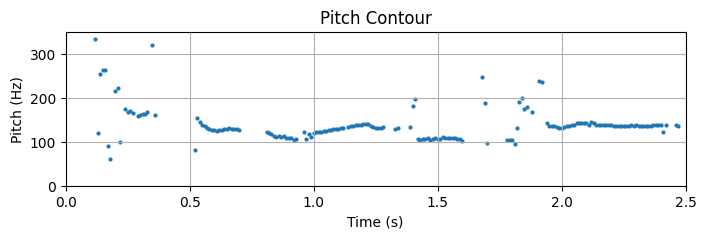

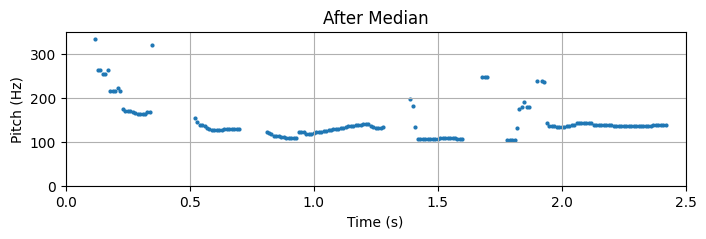

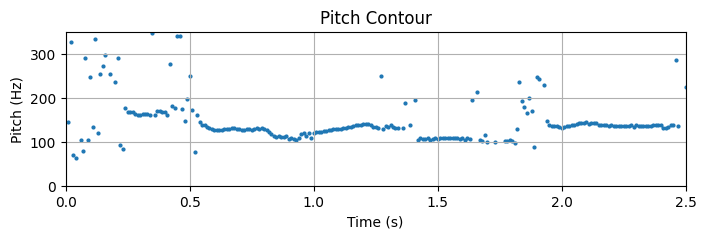

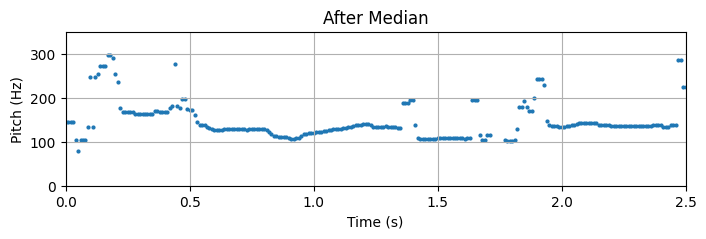

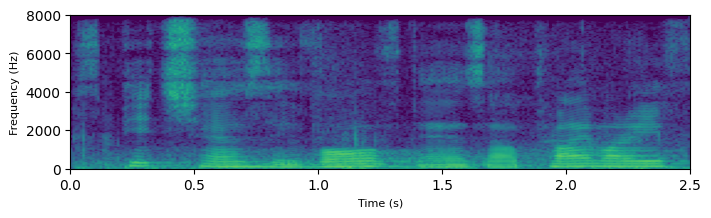

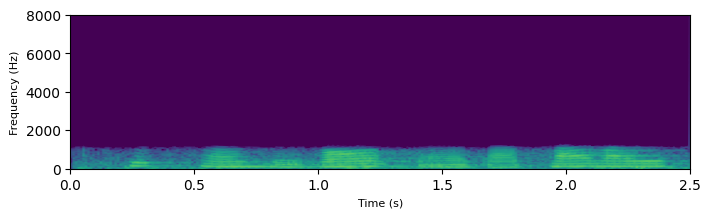

In [7]:
from scipy.signal import find_peaks
from pitchestimate import ThresholdClipper, autocorrelation, plot_pitch_contour

def extract_frames_with_pitch(y, sr=16000, win_type='hamming', win_length=320, hop_length=160, clip=True):
    """ 
    Extract frames, apply center clipping, autocorrelation, and peak estimation for pitch.
    
    ** Returns:
        frame_list: List of windowed frames.
        pitch_list: List of pitch estimates for each frame.
    """
    if win_length < hop_length:
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to hop_length ({hop_length})")
    
    y = np.pad(y, (win_length // 2, win_length // 2), mode='constant', constant_values=0)  # padding
    siglen_pad = len(y)

    # Windowing function
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")

    frame_list = []
    pitch_list = []

    for center in range(win_length // 2, siglen_pad, hop_length):
        if center > siglen_pad - win_length // 2:
            break  # End condition
        start = center - win_length // 2
        end = center + win_length // 2
        frame = y[start:end] * window
        frame_list.append(frame)

        # Step 1: Apply center clipping
        if clip:
            clipper = ThresholdClipper(frame)
            CL = clipper.calculate_thres()
            clipped_frame = clipper.center_clip(CL)
        else: 
            clipped_frame = frame

        # Step 2: Autocorrelation
        ac = autocorrelation(clipped_frame)

        # Step 3: Peak estimation (pitch estimation)
        if np.max(ac) > 0:
            peaks, _ = find_peaks(ac)
            if len(peaks) > 0:
                pitch_period = peaks[np.argmax(ac[peaks])]  # Find peak with the highest autocorrelation value
                pitch_freq = sr / pitch_period if pitch_period != 0 else 0
                pitch_list.append(pitch_freq)
            else:
                pitch_list.append(0)  # No pitch found
        else:
            pitch_list.append(0)  # No pitch found
    
    return frame_list, pitch_list


    
from scipy.signal import medfilt
frames, pitches = extract_frames_with_pitch(y, sr=16000, win_type='hamming', win_length=320, hop_length=160, clip=False)
plot_pitch_contour(pitches, sr=16000, hop_length=160, figsize=(8,2))
pitches = medfilt(pitches, kernel_size=5) 
plot_pitch_contour(pitches, sr=16000, hop_length=160, figsize=(8,2), title='After Median')

frames, pitches = extract_frames_with_pitch(y_lpf, sr=16000, win_type='hamming', win_length=320, hop_length=160, clip=False)
plot_pitch_contour(pitches, sr=16000, hop_length=160, figsize=(8,2))
pitches = medfilt(pitches, kernel_size=5) 
plot_pitch_contour(pitches, sr=16000, hop_length=160, figsize=(8,2), title='After Median')

t=draw_spec(y, win_len=320, hop_len=160, figsize=(8,2), use_colorbar=False, cmap='viridis')    
t=draw_spec(y_lpf, win_len=320, hop_len=160, figsize=(8,2), use_colorbar=False, cmap='viridis')

In [ ]:
# from pitchestimate import amdf

# # Example 5 Hz sine wave
# fs = 1000 
# t = np.linspace(0, 1, fs, endpoint=False) 
# f = 5  
# x = np.sin(2 * np.pi * f * t)  # 5Hz 
# print(len(x))

# max_lag = 200
# amdf_vals = amdf(x, len(x))

# plt.figure(figsize=(10,1))
# plt.plot(x)
# plt.grid()
# plt.show()

# # AMDF 
# plt.figure(figsize=(10, 1))
# plt.plot(amdf_vals)
# plt.title('AMDF of 5 Hz Sine Wave')
# plt.xlabel('Lag')
# plt.ylabel('AMDF Value')
# plt.grid(True)
# plt.show()

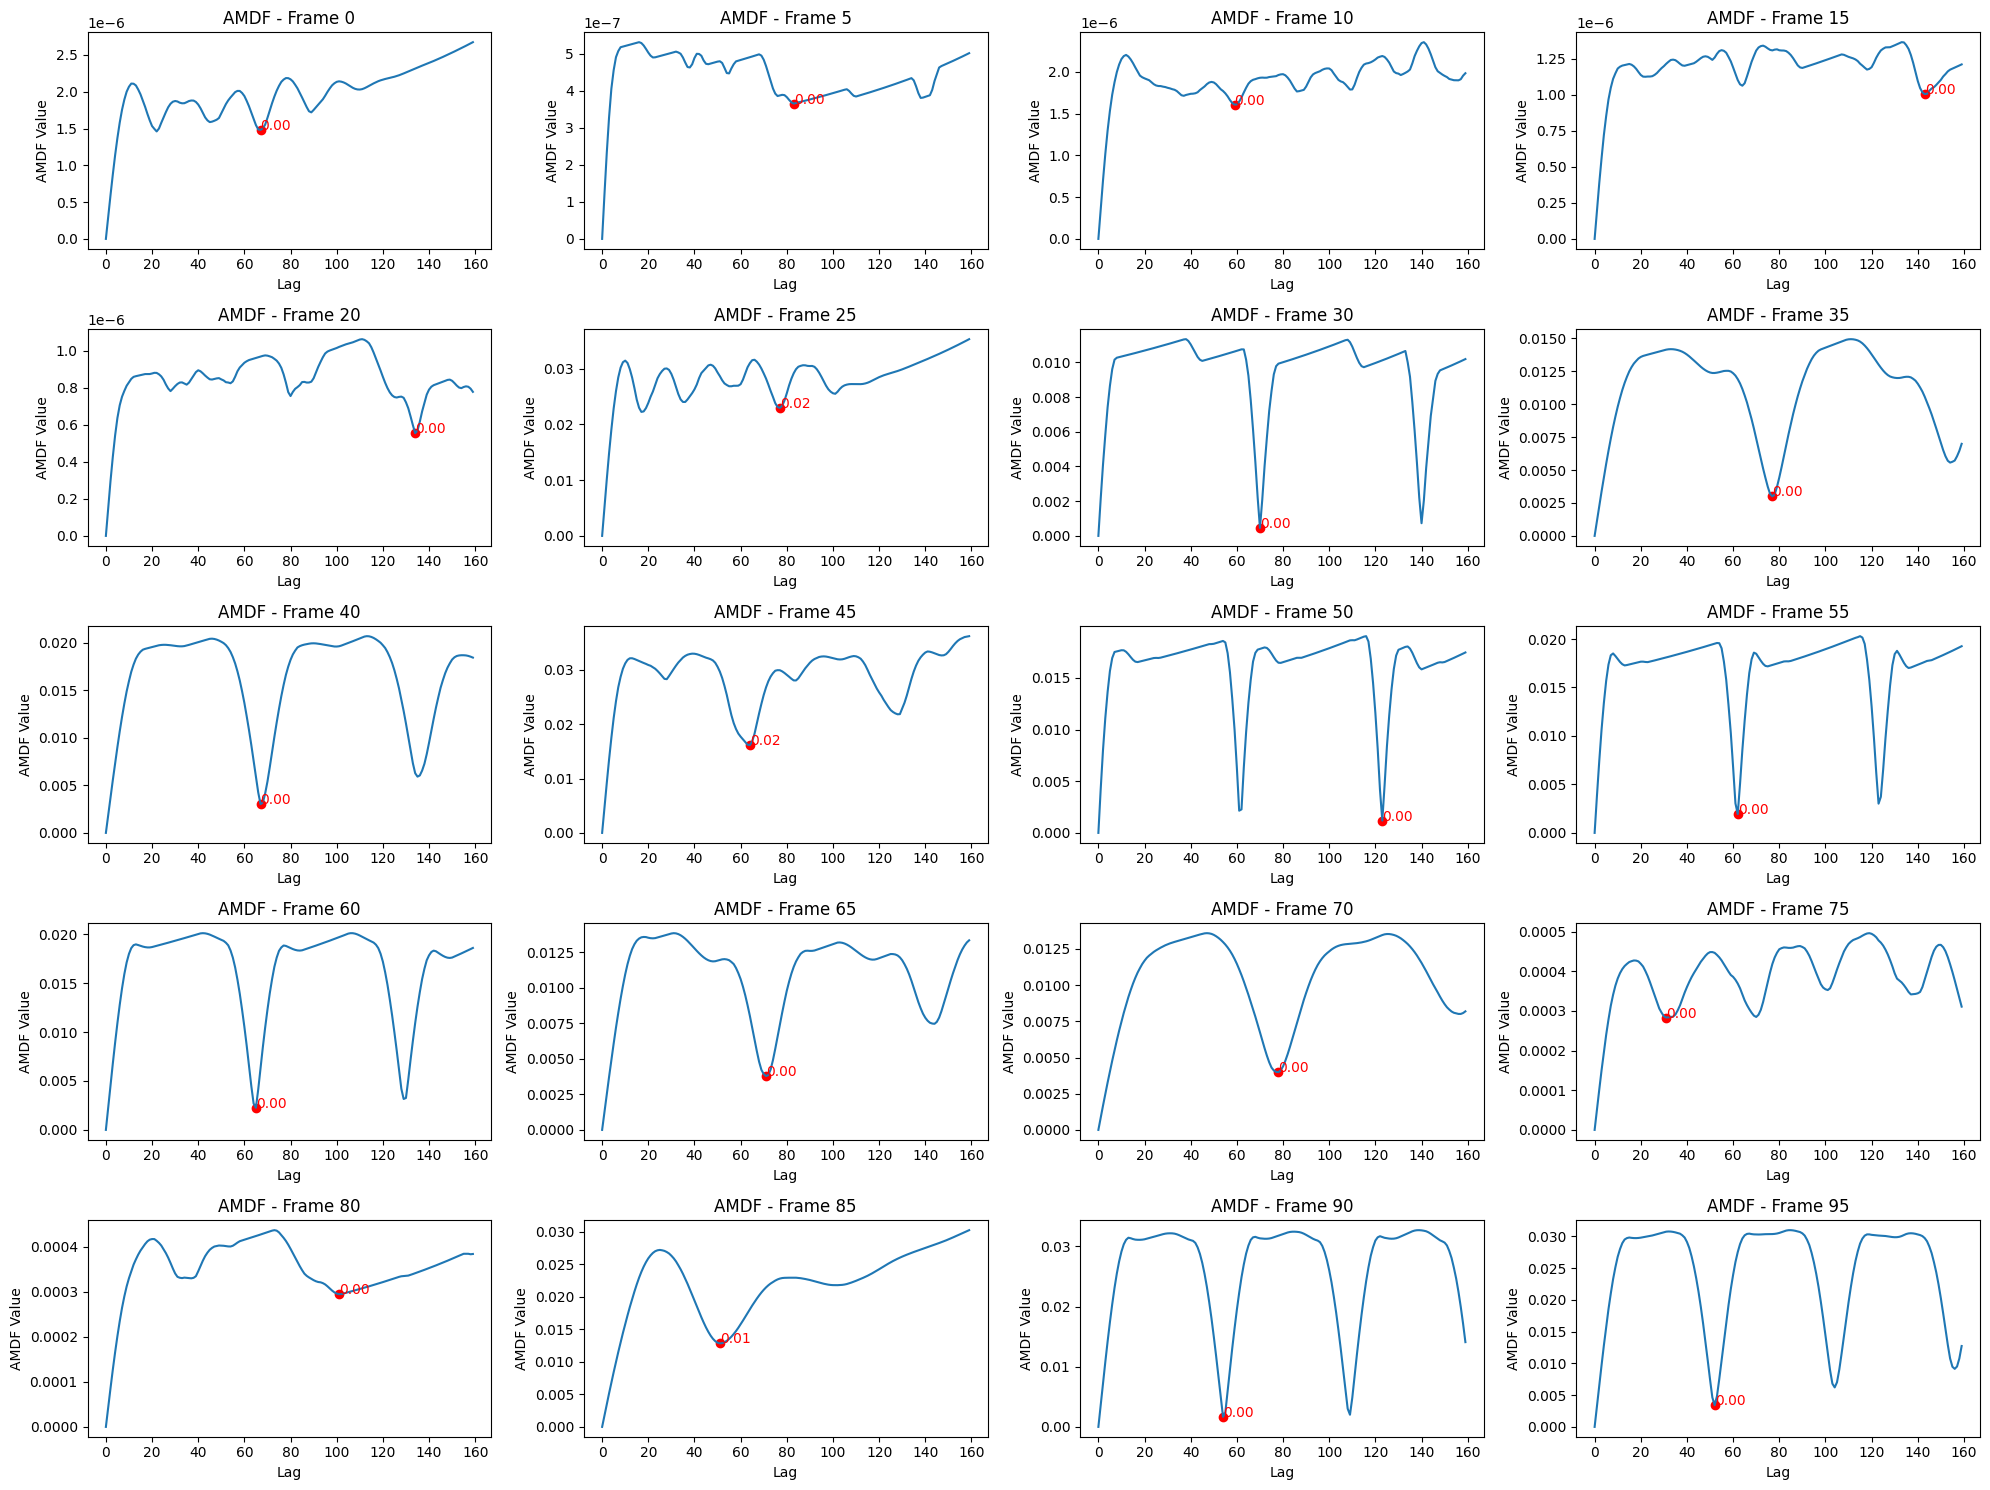

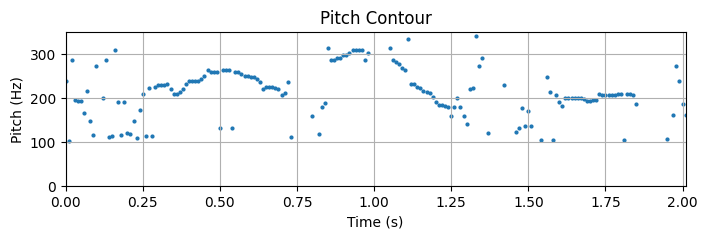

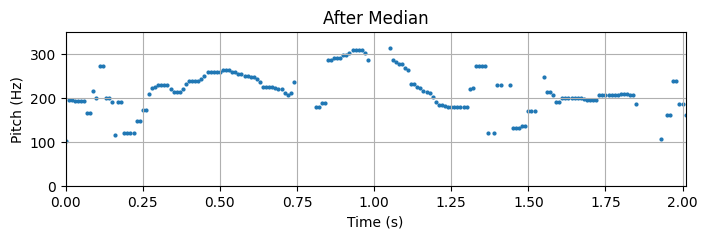

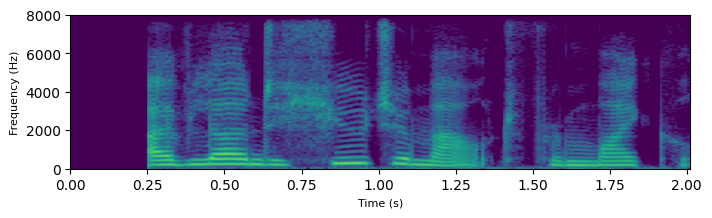

In [8]:
from pitchestimate import ThresholdClipper, plot_pitch_contour, amdf
from scipy.signal import find_peaks, medfilt

def extract_frames_with_pitch_amdf(y, sr=16000, win_type='rectangular', win_length=320, hop_length=160, max_lag=200, plot_amdf=False):
    """ 
    Extract frames, apply center clipping, and use AMDF for pitch estimation.
    
    ** Returns:
        frame_list: List of windowed frames.
        pitch_list: List of pitch estimates for each frame.
    """
    if win_length < hop_length:
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to hop_length ({hop_length})")
    
    y = np.pad(y, (win_length // 2, win_length // 2), mode='constant', constant_values=0)  # padding
    siglen_pad = len(y)

    # Windowing function
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")

    frame_list = []
    pitch_list = []
    amdf_results = []
    num_frames_to_plot = 20 * 5
    frame_indices = []
    cnt = 0
    min_lag_offset = 25

    for center in range(win_length // 2, siglen_pad, hop_length):
        if center > siglen_pad - win_length // 2:
            break  # End condition
        start = center - win_length // 2
        end = center + win_length // 2
        frame = y[start:end] * window
        frame_list.append(frame)

        # Step 1: Apply center clipping
        clipper = ThresholdClipper(frame)
        CL = clipper.calculate_thres()
        clipped_frame = clipper.center_clip(CL)

        # Step 2: Compute AMDF
        amdf_values = amdf(clipped_frame, max_lag)
        if cnt < num_frames_to_plot and cnt % 5 == 0:
            amdf_results.append(amdf_values)  # Store for plotting
            frame_indices.append(cnt)

        # Step 3: Peak estimation (pitch estimation)
        if np.min(amdf_values[min_lag_offset:]) > 0:  # Only consider values after the offset
            peaks, _ = find_peaks(-amdf_values[min_lag_offset:])  # Find minima in AMDF values (since we're looking for minima)
            if len(peaks) > 0:
                pitch_period = peaks[np.argmin(amdf_values[peaks + min_lag_offset])] + min_lag_offset  # Add offset back
                pitch_freq = sr / pitch_period if pitch_period != 0 else 0
                pitch_list.append(pitch_freq)
            else:
                pitch_list.append(0)  # No pitch found
        else:
            pitch_list.append(0)  # No pitch found
        
        cnt += 1
    
    # Plot the AMDF results for the first 20 frames, if plot_amdf is True
    if plot_amdf:
        fig, axes = plt.subplots(5, 4, figsize=(20, 15))  # Create a 5x4 grid of subplots
        axes = axes.flatten()

        for i in range(min(num_frames_to_plot, len(amdf_results))):
            axes[i].plot(amdf_results[i])
            min_val = np.min(amdf_results[i][min_lag_offset:])  # Minimum value after offset
            min_idx = np.argmin(amdf_results[i][min_lag_offset:]) + min_lag_offset  # Index of minimum value
            axes[i].set_title(f'AMDF - Frame {frame_indices[i]}')
            axes[i].set_xlabel('Lag')
            axes[i].set_ylabel('AMDF Value')
            # Highlight the minimum value on the graph
            axes[i].scatter(min_idx, min_val, color='red')
            axes[i].text(min_idx, min_val, f'{min_val:.2f}', fontsize=10, color='red')

        plt.tight_layout()
        plt.show()

    return frame_list, pitch_list

# Usage
y, sr = librosa.load('./sample_crop_16kHz.wav', sr=16000)
y, sr = librosa.load('./s5_180_mic1.flac', sr=16000)
y_lpf = lpf(y, sr=16000, cutoff=1000)
frames, pitches = extract_frames_with_pitch_amdf(y_lpf, sr=16000, win_type='rectangular', win_length=320, hop_length=160, max_lag=160, plot_amdf=True)

# Pitch Contour
plot_pitch_contour(pitches, sr=16000, hop_length=160, figsize=(8,2))
pitches = medfilt(pitches, kernel_size=5)
plot_pitch_contour(pitches, sr=16000, hop_length=160, figsize=(8,2), title='After Median')
t=draw_spec(y, win_len=320, hop_len=160, figsize=(8,2), use_colorbar=False, cmap='viridis')    



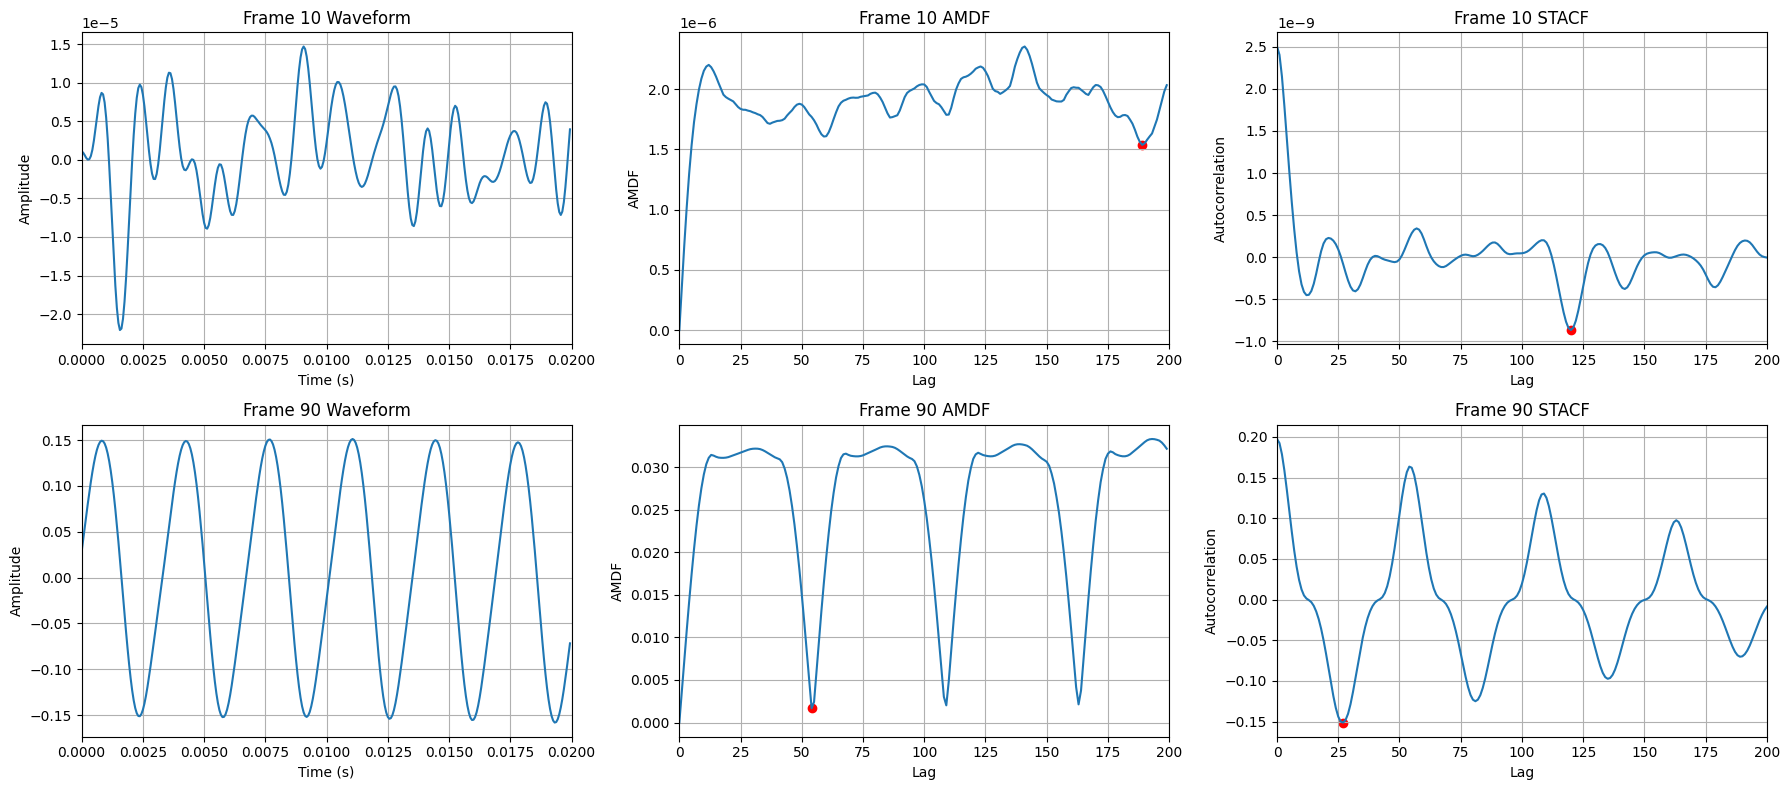

In [10]:
def plot_signal_amdf_stacf(y, sr, frame_idx1, frame_idx2, win_length=320, hop_length=160, max_lag=200, min_lag_offset=25):
    """
    Plot the short-time signal, AMDF, and STACF for two given frame indices in a 2x3 layout.
    """
    # Padding the signal
    y = np.pad(y, (win_length // 2, win_length // 2), mode='constant', constant_values=0)
    
    # Create a figure with 2x3 layout for the two frames
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    
    def process_frame(frame_idx, row):
        # Compute the frame's start and end indices
        center = win_length // 2 + frame_idx * hop_length
        start = center - win_length // 2
        end = center + win_length // 2
        
        # Extract the frame
        frame = y[start:end]
        
        # Apply windowing (rectangular window)
        window = np.ones(win_length)
        frame_windowed = frame * window
        
        # Step 1: Apply center clipping
        clipper = ThresholdClipper(frame_windowed)
        CL = clipper.calculate_thres()
        clipped_frame = clipper.center_clip(CL)
        
        # Step 2: Compute AMDF
        amdf_values = amdf(clipped_frame, max_lag)
        
        # Step 3: Compute STACF (Autocorrelation)
        stacf_values = autocorrelation(clipped_frame)
        
        # Step 4: Find the minimum AMDF value after min_lag_offset
        min_amdf_val = np.min(amdf_values[min_lag_offset:])
        min_amdf_idx = np.argmin(amdf_values[min_lag_offset:]) + min_lag_offset

        # Step 4: Find the minimum AMDF value after min_lag_offset
        max_acf_val = np.min(stacf_values[min_lag_offset:])
        max_acf_idx = np.argmin(stacf_values[min_lag_offset:]) + min_lag_offset
        
        # Plot the short-time signal (waveform)
        axs[row, 0].plot(np.arange(len(frame)) / sr, frame)
        axs[row, 0].set_title(f'Frame {frame_idx} Waveform')
        axs[row, 0].set_xlabel('Time (s)')
        axs[row, 0].set_ylabel('Amplitude')
        axs[row, 0].set_xlim(0, len(frame) / sr)  
        axs[row, 0].grid(True)  # Add grid

        # Plot the AMDF values
        axs[row, 1].plot(amdf_values)
        axs[row, 1].set_title(f'Frame {frame_idx} AMDF')
        axs[row, 1].set_xlabel('Lag')
        axs[row, 1].set_ylabel('AMDF')
        axs[row, 1].scatter(min_amdf_idx, min_amdf_val, color='red')
        axs[row, 1].set_xlim(0, max_lag)
        axs[row, 1].grid(True)

        # Plot the STACF (autocorrelation) values
        axs[row, 2].plot(stacf_values)
        axs[row, 2].set_title(f'Frame {frame_idx} STACF')
        axs[row, 2].set_xlabel('Lag')
        axs[row, 2].set_ylabel('Autocorrelation')
        axs[row, 2].scatter(max_acf_idx, max_acf_val, color='red')
        axs[row, 2].set_xlim(0, max_lag)  
        axs[row, 2].grid(True) 

    # Process both frames
    process_frame(frame_idx1, row=0)
    process_frame(frame_idx2, row=1)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
y, sr = librosa.load('./s5_180_mic1.flac', sr=16000)
y_lpf = lpf(y, sr=16000, cutoff=1000)

# Plot Frame 40 and Frame 90 (2x3 layout in one figure)
plot_signal_amdf_stacf(y_lpf, sr, frame_idx1=10, frame_idx2=90, win_length=320, hop_length=160, max_lag=200)